In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.stats import rankdata, levene, shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

from ertk.classification import (
    dataset_cross_validation,
    dataset_train_val_test,
    get_balanced_sample_weights,
    standard_class_scoring,
)
from ertk.config import get_arg_mapping
from ertk.dataset import load_datasets_config, Dataset
from ertk.sklearn.models import get_sk_model
from ertk.sklearn.utils import GridSearchVal
from ertk.train import ExperimentConfig, ValidationSplit, get_cv_splitter, get_scores, scores_to_df

%matplotlib inline
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [113]:
emofilm = Dataset("../../datasets/EmoFilm/corpus.yaml", subset="all")
print(emofilm)
en_idx = emofilm.get_idx_for_split({"language": ["en"]})
es_idx = emofilm.get_idx_for_split({"language": ["es"]})
it_idx = emofilm.get_idx_for_split({"language": ["it"]})

Corpus: EmoFilm
Description: EmoFilm dataset
partition 'film' (43 groups)
partition 'gender' (2 groups)
	{'f': 537, 'm': 578}
partition 'label' (5 groups)
	{'anger': 232, 'disgust': 168, 'fear': 221, 'happiness': 240, 'sadness': 254}
partition 'language' (3 groups)
	{'en': 343, 'es': 359, 'it': 413}
partition 'speaker' (202 groups) (incomplete [1093 valid])
1115 instances
Subsets:
	*all: 1115 instances
using  (0 features)



In [114]:
clf = get_sk_model("lr", **get_arg_mapping("../../conf/clf/sk/lr/default.yaml"))
clf = Pipeline([("transform", StandardScaler()), ("clf", clf)])
print(clf)
scoring = standard_class_scoring(emofilm.classes)

METRICS = ["uar", "war", "macrof1"] + [f"{x}_f1" for x in emofilm.classes]
# FEATURES = "wav2vec_c_mean"
FEATURES = "wav2vec2_audeering_ft_c_mean"

Pipeline(steps=[('transform', StandardScaler()),
                ('clf', LogisticRegression(C=1, multi_class='multinomial'))])


In [115]:
def fit_and_score(clf, x_train, y_train, x_test, y_test):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    sample_weight = get_balanced_sample_weights(y_train)
    clf.fit(x_train, y_train, clf__sample_weight=sample_weight)
    y_pred = clf.predict(x_test)
    scores_df = scores_to_df(get_scores(scoring, y_pred, y_test))
    cm = confusion_matrix(y_test, y_pred, normalize="all")
    return scores_df, cm

## Within-language film-dependent

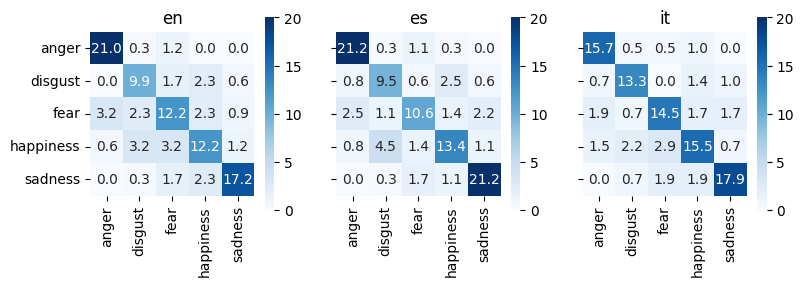

In [116]:
emofilm.update_features(FEATURES)

def run(idx):
    sub_x = emofilm.x[idx]
    sub_y = emofilm.y[idx]
    sub_spk = emofilm.get_group_indices("film")[idx]
    cv = get_cv_splitter(False, 10, shuffle=True, random_state=54321)
    jobs = []
    for i, (train, test) in enumerate(cv.split(sub_x, sub_y, sub_spk)):
        jobs.append(delayed(fit_and_score)(clf, sub_x[train], sub_y[train], sub_x[test], sub_y[test]))
    res = Parallel(n_jobs=10)(jobs)
    scores_df = pd.concat([x[0] for x in res]).mean(numeric_only=True)
    cm = pd.DataFrame(np.mean([x[1] for x in res], axis=0), index=emofilm.classes, columns=emofilm.classes)
    return scores_df, cm

en_df, cm_en = run(en_idx)
es_df, cm_es = run(es_idx)
it_df, cm_it = run(it_idx)

within_fd_df = pd.concat([en_df, es_df, it_df], keys=["en", "es", "it"]).unstack()

fig, ax = plt.subplots(1, 3, figsize=(9, 2.5), sharex=True, sharey=True)
sns.heatmap(cm_en * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0])
ax[0].set_title("en")
sns.heatmap(cm_es * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1])
ax[1].set_title("es")
sns.heatmap(cm_it * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[2])
ax[2].set_title("it")
plt.show()

## Within-language film-independent

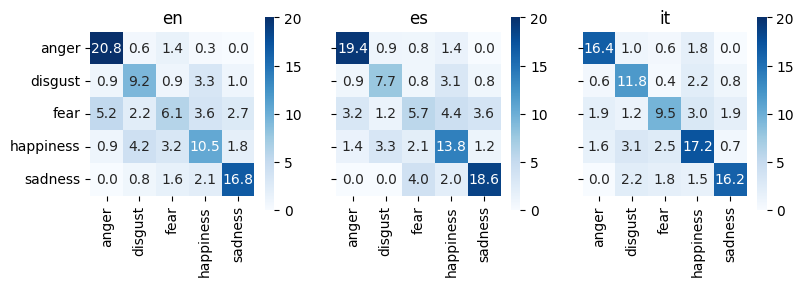

In [117]:
emofilm.update_features(FEATURES)

def run(idx):
    sub_x = emofilm.x[idx]
    sub_y = emofilm.y[idx]
    sub_spk = emofilm.get_group_indices("film")[idx]
    cv = get_cv_splitter(True, 5, shuffle=True, random_state=54321)
    jobs = []
    for i, (train, test) in enumerate(cv.split(sub_x, sub_y, sub_spk)):
        jobs.append(delayed(fit_and_score)(clf, sub_x[train], sub_y[train], sub_x[test], sub_y[test]))
    res = Parallel(n_jobs=10)(jobs)
    scores_df = pd.concat([x[0] for x in res]).mean(numeric_only=True)
    cm = pd.DataFrame(np.mean([x[1] for x in res], axis=0), index=emofilm.classes, columns=emofilm.classes)
    return scores_df, cm

en_df, cm_en = run(en_idx)
es_df, cm_es = run(es_idx)
it_df, cm_it = run(it_idx)

within_fi_df = pd.concat([en_df, es_df, it_df], keys=["en", "es", "it"]).unstack()

fig, ax = plt.subplots(1, 3, figsize=(9, 2.5), sharex=True, sharey=True)
sns.heatmap(cm_en * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0])
ax[0].set_title("en")
sns.heatmap(cm_es * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1])
ax[1].set_title("es")
sns.heatmap(cm_it * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[2])
ax[2].set_title("it")
plt.show()

## Cross-language

### Pairwise

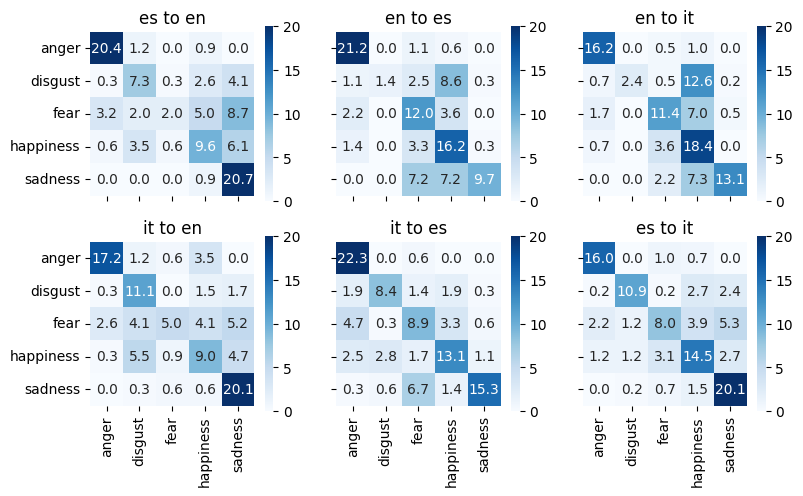

In [118]:
preds = np.load(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/en__es.preds.npy")[0]
cm_en_es = pd.DataFrame(confusion_matrix(emofilm.y[es_idx], preds, normalize="all"), index=emofilm.classes, columns=emofilm.classes)
en_es_df = pd.read_csv(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/en__es.csv", index_col=[0, 1]).mean(numeric_only=True)

preds = np.load(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/en__it.preds.npy")[0]
cm_en_it = pd.DataFrame(confusion_matrix(emofilm.y[it_idx], preds, normalize="all"), index=emofilm.classes, columns=emofilm.classes)
en_it_df = pd.read_csv(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/en__it.csv", index_col=[0, 1]).mean(numeric_only=True)

preds = np.load(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/es__en.preds.npy")[0]
cm_es_en = pd.DataFrame(confusion_matrix(emofilm.y[en_idx], preds, normalize="all"), index=emofilm.classes, columns=emofilm.classes)
es_en_df = pd.read_csv(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/es__en.csv", index_col=[0, 1]).mean(numeric_only=True)

preds = np.load(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/es__it.preds.npy")[0]
cm_es_it = pd.DataFrame(confusion_matrix(emofilm.y[it_idx], preds, normalize="all"), index=emofilm.classes, columns=emofilm.classes)
es_it_df = pd.read_csv(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/es__it.csv", index_col=[0, 1]).mean(numeric_only=True)

preds = np.load(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/it__en.preds.npy")[0]
cm_it_en = pd.DataFrame(confusion_matrix(emofilm.y[en_idx], preds, normalize="all"), index=emofilm.classes, columns=emofilm.classes)
it_en_df = pd.read_csv(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/it__en.csv", index_col=[0, 1]).mean(numeric_only=True)

preds = np.load(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/it__es.preds.npy")[0]
cm_it_es = pd.DataFrame(confusion_matrix(emofilm.y[es_idx], preds, normalize="all"), index=emofilm.classes, columns=emofilm.classes)
it_es_df = pd.read_csv(f"./results/pairwise/{FEATURES}/emofilm_cross_lang_5class/it__es.csv", index_col=[0, 1]).mean(numeric_only=True)

cross_pair_df = pd.concat([es_en_df, it_en_df, en_es_df, it_es_df, en_it_df, es_it_df], keys=["es_en", "it_en", "en_es", "it_es", "en_it", "es_it"]).unstack()

fig, ax = plt.subplots(2, 3, figsize=(9, 5), sharex=True, sharey=True)
sns.heatmap(cm_es_en * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0, 0])
ax[0, 0].set_title("es to en")
sns.heatmap(cm_it_en * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1, 0])
ax[1, 0].set_title("it to en")
sns.heatmap(cm_en_es * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0, 1])
ax[0, 1].set_title("en to es")
sns.heatmap(cm_it_es * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1, 1])
ax[1, 1].set_title("it to es")
sns.heatmap(cm_en_it * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0, 2])
ax[0, 2].set_title("en to it")
sns.heatmap(cm_es_it * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1, 2])
ax[1, 2].set_title("es to it")
plt.show()

### LOGO

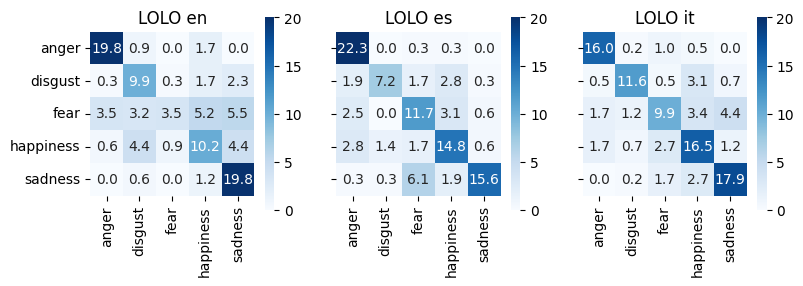

In [119]:
emofilm.update_features(FEATURES)

sub_x = emofilm.x
sub_y = emofilm.y
sub_spk = emofilm.get_group_indices("language")
cv = get_cv_splitter(True, -1)
jobs = []
for i, (train, test) in enumerate(cv.split(sub_x, sub_y, sub_spk)):
    jobs.append(delayed(fit_and_score)(clf, sub_x[train], sub_y[train], sub_x[test], sub_y[test]))
res = Parallel(n_jobs=3)(jobs)
cross_logo_df = pd.concat([x[0] for x in res], keys=emofilm.get_group_names("language")).droplevel("fold")
cm = pd.concat([pd.DataFrame(x[1], index=emofilm.classes, columns=emofilm.classes) for x in res], keys=emofilm.get_group_names("language"))

fig, ax = plt.subplots(1, 3, figsize=(9, 2.5), sharex=True, sharey=True)
sns.heatmap(cm.loc["en"] * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0])
ax[0].set_title("LOLO en")
sns.heatmap(cm.loc["es"] * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1])
ax[1].set_title("LOLO es")
sns.heatmap(cm.loc["it"] * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[2])
ax[2].set_title("LOLO it")
plt.show()

## Combined table

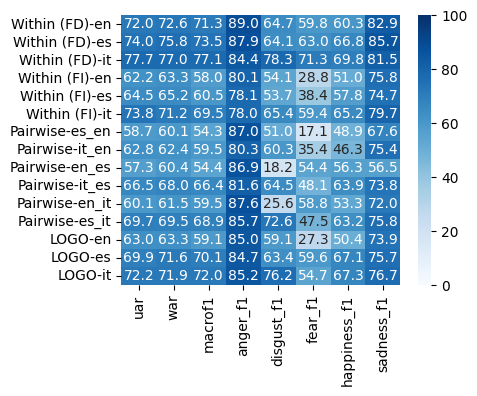

In [120]:
results_df = pd.concat([within_fd_df, within_fi_df, cross_pair_df, cross_logo_df], keys=["Within (FD)", "Within (FI)", "Pairwise", "LOGO"])
results_df = results_df[METRICS] * 100
fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.heatmap(results_df, vmin=0, vmax=100, cmap="Blues", annot=True, fmt=".1f", ax=ax)
ax.set_ylabel(None)
plt.show()

In [121]:
print((results_df.loc["Within (FI)"] - results_df.loc["Within (FD)"]).to_latex(float_format="{:.1f}".format))
pair_mean = results_df.loc["Pairwise"].assign(tgt=results_df.loc["Pairwise"].index.str[-2:]).groupby("tgt").mean()
print((pair_mean - results_df.loc["Within (FI)"]).to_latex(float_format="{:.1f}".format))
print((results_df.loc["LOGO"] - results_df.loc["Within (FI)"]).to_latex(float_format="{:.1f}".format))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  uar &   war &  macrof1 &  anger\_f1 &  disgust\_f1 &  fear\_f1 &  happiness\_f1 &  sadness\_f1 \\
\midrule
en & -9.8 &  -9.3 &    -13.4 &      -8.9 &       -10.6 &    -31.1 &          -9.3 &        -7.1 \\
es & -9.5 & -10.5 &    -12.9 &      -9.8 &       -10.3 &    -24.6 &          -8.9 &       -10.9 \\
it & -3.9 &  -5.8 &     -7.5 &      -6.4 &       -12.9 &    -11.9 &          -4.6 &        -1.8 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  uar &  war &  macrof1 &  anger\_f1 &  disgust\_f1 &  fear\_f1 &  happiness\_f1 &  sadness\_f1 \\
tgt &      &      &          &           &             &          &               &             \\
\midrule
en  & -1.5 & -2.1 &     -1.0 &       3.5 &         1.6 &     -2.5 &          -3.5 &        -4.3 \\
es  & -2.6 & -1.0 &     -0.1 &       6.2 &       -12.4 &     12.9 &           2.3 &        -9.6 \\
it  & -8.8 & -5.7 &     -5.3 &       8.7 &       -16.2 &     -6.3 &          -6.9 

/tmp/ipykernel_3966170/4180424252.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((results_df.loc["Within (FI)"] - results_df.loc["Within (FD)"]).to_latex(float_format="{:.1f}".format))
/tmp/ipykernel_3966170/4180424252.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((pair_mean - results_df.loc["Within (FI)"]).to_latex(float_format="{:.1f}".format))
/tmp/ipykernel_3966170/4180424252.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected